In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


In [2]:
df_all = pd.DataFrame()

In [3]:
perp_folders = ["../output/stance_detection_debug/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file:
            continue 
        
        if "stance_detection" not in file:
            continue 
                
        if ".log" in file:
            continue
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "proportions" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        
        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])


../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints/seed_2_checkpoint-600.pkl
../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints/seed_1_checkpoint-300.pkl
../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints/seed_3_checkpoint-100.pkl
../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints/seed_0_checkpoint-400.pkl
../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints/seed_4_checkpoint-100.pkl
../output/stance_detection_debug/ni_600_mixture_stance_detection_text_matching_target

In [5]:
def aggregate_skill(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "skill_perplexity"
        metric = total_ppl/count_ppl
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "skill_loss"
        metric = total_loss/count_loss

    names = {metric_name: metric}
    
    return pd.Series(names, index=[metric_name])



In [6]:
sorted(df_all.method.unique())

['ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.1_lookback_3_checkpoints',
 'ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.2_lookback_3_checkpoints',
 'ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.5_lookback_3_checkpoints',
 'ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.8_lookback_3_checkpoints',
 'ni_600_mixture_stance_detection_text_matching_weights_10_static',
 'ni_600_stratified_stance_detection_text_matching_static']

[0 4 3 2 1]
checkpoint
600    1.474122
600    1.442103
600    1.317268
600    1.599521
600    1.462725
Name: skill_loss, dtype: float64
[0 4 3 2 1]
checkpoint
600    1.325118
600    1.302112
600    1.186347
600    1.375648
600    1.306301
Name: skill_loss, dtype: float64
[3 4 0 1 2]
checkpoint
600    1.324378
600    1.262901
600    1.171677
600    1.279595
600    1.277097
Name: skill_loss, dtype: float64


Text(0.5, 1.0, 'Targeted learning of stance detection')

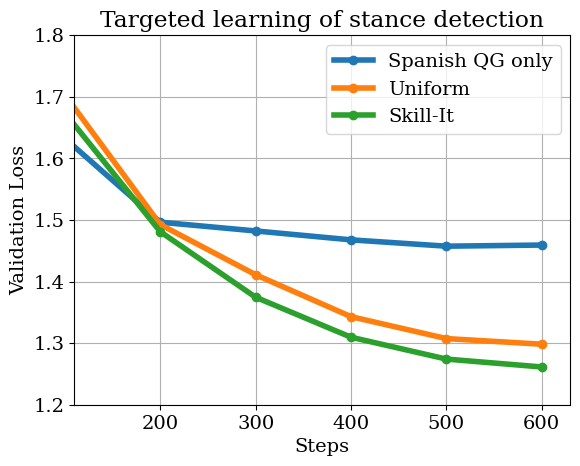

In [8]:


methods = ["ni_600_mixture_stance_detection_text_matching_weights_10_static",
           "ni_600_stratified_stance_detection_text_matching_static",
           "ni_600_mixture_stance_detection_text_matching_targetmask_10_mean_stance_detection_greedy_100_eta_0.2_lookback_3_checkpoints"
]
plt.figure()
seeds=[0, 1, 2, 3, 4]

labels = ["Spanish QG only", "Uniform", "Skill-It"]

for i, method in enumerate(methods):
    
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_per_seed = df_shuffled.groupby([df_shuffled.index, "skill", "seed"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_per_seed.set_index("checkpoint", inplace=True)
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_shuffled.loc[df_shuffled.skill == "stance_detection"].skill_loss.plot(marker="o", label=labels[i], lw=4)
    print(df_per_seed.loc[(df_per_seed.index == df_per_seed.index.max()) & (df_per_seed.skill == "stance_detection")].skill_loss)

plt.xlim(110,)
plt.ylim(1.2, 1.8)

plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
plt.grid()
plt.title("Targeted learning of stance detection")


Learn the graph